In [335]:
%matplotlib inline
from operator import itemgetter
import json
import itertools
from logger import Logger
import argparse
import numpy as np
import matplotlib as mpl

import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
from scipy.signal import savgol_filter
from scipy.interpolate import splprep, splev
import pandas as pd
from plot_utils import *

In [336]:
def get_experiment_list(algorithm='pd_const',dataset='digits',char='best',name=None):
    
    if name is None:
        log_list_name = '{0}_{1}_{2}'.format(algorithm,dataset,char)
    else:log_list_name = name
    return d.item().get(log_list_name)

In [337]:
def learning_curves(run_id,feature='time',phase='train'):
    lg = Logger()
    lg_file = lg.load(run_id)
    lg_list = lg_file.get(phase)
    feat = [lg_list[i][feature] for i in range(len(lg_list))]
    return feat

In [402]:
def plot_basic(ax, experiments, algo=None, key1=[], key2=[], title='Loss', ylabel=None, y_limit=None, labels=None, colors =None, \
               linestyles=None, hide_y = False):
    exlog = experiments 
    xlabel = 'Iterations'
    if title == 'losst':xlabel = 'Time (msec)'
    x, y = [], []
    for id_no,run_id in enumerate(exlog):

        try:
            logger = Logger.load(run_id)
        except ValueError:
            continue

        for j in range(len(key1)):
            y = [v[key1[j]] for v in logger.get(key2[j])]
            x = np.arange(len(y))+1
            label = labels[id_no*len(key1)+j]
            color = colors[id_no]
            linestyle = linestyles[j]
            
            if 'loss' in title:
                ax.set_yscale('log')
                ax.set_xscale('log')
                    
            if title == 'losst':
                x = np.cumsum([v['time'] for v in logger.get(key2[j])])
                
            #ax.get_xaxis().set_major_formatter(matplotlib.ticker.LogFormatter())
            #ax.xaxis.set_major_locator(tck.MultipleLocator(base=50))
            #ax.grid()
            if 'admm' in run_id and title == 'acc':y = savgol_filter(y,5,1)
            ax.grid(True,which="both",ls="-",lw=0.5)
            ax.plot(x, y, label=label, color=color,linestyle=linestyle)
            ax.set_xlabel(xlabel,size=16)
            
#     if 'acc' in title:
#         ax.set_ylim(top=1.05,bottom=0)
#         ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#         ax.yaxis.set_major_locator(tck.MultipleLocator(base=.25))
#         ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#         ax.xaxis.set_major_locator(tck.MultipleLocator(base=25))

    ax.tick_params(labelsize=14)

    if y_limit is not None:
        ax.set_ylim(top=y_limit[0],bottom=y_limit[1])
    ax.set_ylabel(ylabel,size=16)

    if 'loss' in title:
        title='Objective : ||Y\u03BC - XW||_1'
    elif title=='acc':
        title='Training/Test Accuracy'
    elif title == 'p_residue':
        title='Primal Residue v.s. k'
    
    if title is not None:
        ax.set_title(title,fontsize=14)

    if hide_y:
        ax.yaxis.label.set_visible(False)
        
    legend_size = 12
    legend_loc = 'best'
    legend_fo = True
#     if 'admm' in algo and 'ject' in title:
#         legend_size = 6
#         legend_loc = 'center'
#         legend_fo = False
    ax.legend(prop={'size': legend_size},loc=legend_loc,bbox_to_anchor=(1.0,0.9),\
              fontsize=10,ncol=1,fancybox=True,frameon=False)

In [421]:
def plot_sen(ax, experiments, title='Loss', ylabel=None, xlabel=None, y_limit=None, labels=None, colors=None, \
               hide_y = False):
    
    exlog = experiments 

    for id_no,run_id in enumerate(exlog):

        d = np.load('./Dicts/{0}.npy'.format(run_id)).item()
        x = d['x']
        y = d['y']
        
        label = labels[id_no]
        color = colors[id_no]

        ax.set_yscale('log')
        ax.set_xscale('log')

        ax.grid(True,which="both",ls="-",lw=0.5)
        ax.plot(x, y, label=label, color=color, marker='o')
        ax.set_xlabel(xlabel,size=16)
            
    ax.tick_params(labelsize=14)

    if y_limit is not None:
        ax.set_ylim(top=y_limit[0],bottom=y_limit[1])
    ax.set_ylabel(ylabel,size=16)
    
    if title is not None:
        ax.set_title(title,fontsize=14)

    if hide_y:
        ax.yaxis.label.set_visible(False)
        
    legend_size = 12
    legend_loc = 'best'
    legend_fo = True

    ax.legend(prop={'size': legend_size},loc=legend_loc,#bbox_to_anchor=(1.0,0.9),\
              fontsize=10,ncol=1,fancybox=True,frameon=False)

In [415]:
def plot_combined(algo=None,label_id=None,suptitle=None,dataset=None,figname=None,\
                      key1=[],key2=[],y_limit=None,title=None,ylabel=None):
    experiment_list = ['{0}_soft_{1}'.format(algo,dataset),'{0}_const_{1}'.format(algo,dataset),\
                       '{0}_const_over_{1}'.format(algo,dataset),'{0}_frob_{1}'.format(algo,dataset),\
                       '{0}_frob_over_{1}'.format(algo,dataset),'{0}_elastic_{1}'.format(algo,dataset)]

    label_list = ['{0}-soft-Train'.format(label_id),'{0}-soft-Test'.format(label_id),'{0}-l1-Train'.format(label_id),\
                  '{0}-l1-Test'.format(label_id),'{0}-l1-over-Train'.format(label_id),\
                  '{0}-l1-over-Test'.format(label_id),'{0}-frob-Train'.format(label_id),\
                  '{0}-frob-Test'.format(label_id),'{0}-frob-over-Train'.format(label_id),\
                  '{0}-frob-over-Test'.format(label_id),'{0}-elastic-Train'.format(label_id),\
                  '{0}-elastic-Test'.format(label_id)]

    color_idx = np.linspace(0, 1, len(experiment_list)+1)
    c_list = []
    for i in range(len(color_idx)):
        c_list.append(plt.cm.hsv(color_idx[i]))

    fig, (ax1) = plt.subplots(1, 1, figsize=(1 + 1*6, 5), sharey=False)
    ax1 = plot_basic(ax1,experiments=experiment_list,key1=key1,\
                     key2=key2, colors=c_list,linestyles=['-',':'],\
                     labels=label_list,y_limit=y_limit,\
                     algo=algo,
                     ylabel=ylabel,title=title)
    fig.suptitle(suptitle,x=0.54,y=1.03,size=14)
    fig.tight_layout()
    fig.savefig('Plots/{0}.pdf'.format(figname), format='pdf', bbox_inches='tight')

In [416]:
def plot_combined_sen(param=None,algo=None,label_id=None,suptitle=None,dataset=None,figname=None,\
                      y_limit=None,title=None,ylabel=None,xlabel=None):
    
    experiment_list = ['{0}_const_{1}_sen_{2}'.format(algo,dataset,param),\
                       '{0}_const_over_{1}_sen_{2}'.format(algo,dataset,param),\
                       '{0}_frob_{1}_sen_{2}'.format(algo,dataset,param),\
                       '{0}_frob_over_{1}_sen_{2}'.format(algo,dataset,param),\
                       '{0}_elastic_{1}_sen_{2}'.format(algo,dataset,param)]

    label_list = [
                  '{0}-l1-Test'.format(label_id),\
                  '{0}-l1-over-Test'.format(label_id),\
                  '{0}-frob-Test'.format(label_id),\
                  '{0}-frob-over-Test'.format(label_id),\
                  '{0}-elastic-Test'.format(label_id)]

    color_idx = np.linspace(0, 1, len(experiment_list)+1)
    c_list = []
    for i in range(len(color_idx)):
        c_list.append(plt.cm.hsv(color_idx[i]))
        
    fig, (ax1) = plt.subplots(1, 1, figsize=(1 + 1*6, 5), sharey=False)
    ax1 = plot_sen(ax1,experiments=experiment_list,\
                     colors=c_list,\
                     labels=label_list,y_limit=y_limit,\
                     ylabel=ylabel,xlabel=xlabel,title=title)
    fig.suptitle(suptitle,x=0.57,y=1.03,size=14)
    fig.tight_layout()
    fig.savefig('Plots/{0}.pdf'.format(figname), format='pdf', bbox_inches='tight')

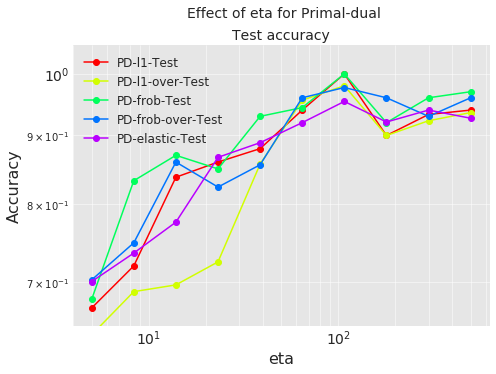

In [427]:
plot_combined_sen(param='eta',algo='pd',label_id='PD',suptitle='Effect of eta for Primal-dual',\
                  dataset='syn',figname='pd_syn_eta_sen',\
                  y_limit=[1.05,0.65],title='Test accuracy',ylabel='Accuracy',xlabel='eta')

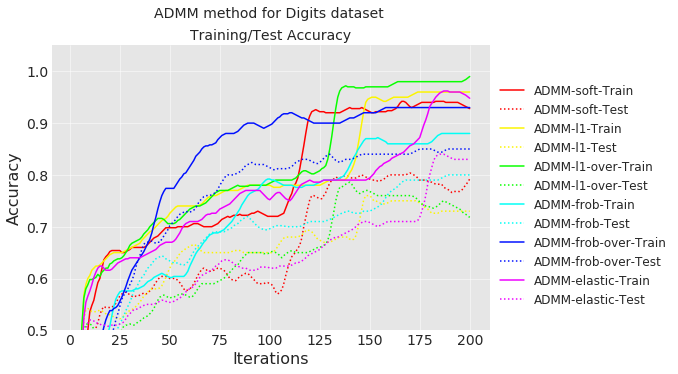

In [407]:
plot_combined(algo='admm',label_id='ADMM',suptitle='ADMM method for Digits dataset',\
                  dataset='digits',figname='comb_admm_digits_all',key1=['acc','acc'],\
                  key2=['train','test'],y_limit=[1.05,0.5],title='acc',ylabel='Accuracy')

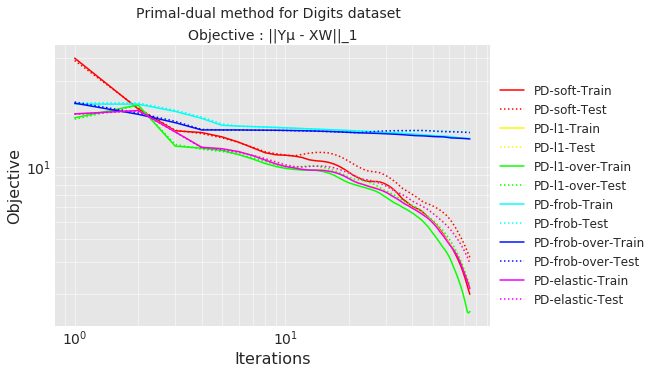

In [413]:
plot_combined(algo='pd',label_id='PD',suptitle='Primal-dual method for Digits dataset',\
                  dataset='digits',figname='comb_pd_digits_all_obj',key1=['t1','t1'],\
                  key2=['train','test'],y_limit=None,title='loss',ylabel='Objective')

In [330]:
algo='admm'
dataset='digits'

In [331]:
experiment_list = ['{0}_soft_{1}'.format(algo,dataset),'{0}_const_{1}'.format(algo,dataset),\
                   '{0}_const_over_{1}'.format(algo,dataset),'{0}_frob_{1}'.format(algo,dataset),\
                   '{0}_frob_over_{1}'.format(algo,dataset),'{0}_elastic_{1}'.format(algo,dataset)]

In [332]:
for i in range(len(experiment_list)):
    print(experiment_list[i],np.mean(np.array(learning_curves(experiment_list[i])))*1000)

admm_soft_digits 0.27963757514953613
admm_const_digits 0.317685604095459
admm_const_over_digits 0.3318953514099121
admm_frob_digits 0.34921884536743164
admm_frob_over_digits 0.35662174224853516
admm_elastic_digits 0.2951180934906006


In [323]:
np.mean(np.array(learning_curves('pd_elastic_syn')))*1000

0.7109475135803223

In [289]:
def plot_combined_obj(algo=None,label_id=None,suptitle=None,dataset=None,figname=None,):
    experiment_list = ['{0}_soft_{1}'.format(algo,dataset),'{0}_const_{1}'.format(algo,dataset),\
                       '{0}_const_over_{1}'.format(algo,dataset),'{0}_frob_{1}'.format(algo,dataset),\
                       '{0}_frob_over_{1}'.format(algo,dataset),'{0}_elastic_{1}'.format(algo,dataset)]

    label_list = ['{0}-soft-Train'.format(label_id),'{0}-soft-Test'.format(label_id),'{0}-const-Train'.format(label_id),\
                  '{0}-const-Test'.format(label_id),'{0}-const-over-Train'.format(label_id),\
                  '{0}-const-over-Test'.format(label_id),'{0}-frob-Train'.format(label_id),\
                  '{0}-frob-Test'.format(label_id),'{0}-frob-over-Train'.format(label_id),\
                  '{0}-frob-over-Test'.format(label_id),'{0}-elastic-Train'.format(label_id),\
                  '{0}-elastic-Test'.format(label_id)]

    color_idx = np.linspace(0, 1, len(experiment_list)+1)
    c_list = []
    for i in range(len(color_idx)):
        c_list.append(plt.cm.hsv(color_idx[i]))

    fig, (ax1) = plt.subplots(1, 1, figsize=(1 + 1*6, 5), sharey=False)
    ax1 = plot_basic(ax1,experiments=experiment_list,key1=['acc','acc'],\
                     key2=['train','test'], colors=c_list,linestyles=['-',':'],\
                     labels=label_list,y_limit=[1.05,0.5],\
                     algo=algo,
                     ylabel='Accuracy',title='acc')
    fig.suptitle(suptitle,x=0.54,y=1.03,size=14)
    fig.tight_layout()
    fig.savefig('Plots/{0}.pdf'.format(figname), format='pdf', bbox_inches='tight')

In [217]:
def get_lists(algo,dataset,label_id,tot):
    e_list = ['{0}_soft_{1}'.format(algo,dataset),'{0}_const_{1}'.format(algo,dataset),\
                       '{0}_const_over_{1}'.format(algo,dataset),'{0}_frob_{1}'.format(algo,dataset),\
                       '{0}_frob_over_{1}'.format(algo,dataset),'{0}_elastic_{1}'.format(algo,dataset)]
    label_list = ['{0}-soft-{1}'.format(label_id,tot),'{0}-const-{1}'.format(label_id,tot),\
                  '{0}-const-over-{1}'.format(label_id,tot),'{0}-frob-{1}'.format(label_id,tot),\
                  '{0}-frob-over-{1}'.format(label_id,tot),'{0}-elastic-{1}'.format(label_id,tot),]
    return e_list,label_list

In [235]:
def plot_combined_acc_total(suptitle=None,dataset=None,figname=None,tot=None):

    e1,l1 = get_lists(algo='pd',dataset=dataset,label_id='PD',tot=tot)
    e2,l2 = get_lists(algo='admm',dataset=dataset,label_id='ADMM',tot=tot)
        
    experiment_list = []
    label_list = []

    for i in range(len(e1)):
        experiment_list.append(e1[i])
        experiment_list.append(e2[i])
        label_list.append(l1[i])
        label_list.append(l2[i])
        
    color_idx = np.linspace(0, 1, len(experiment_list)+1)
    c_list = []
    for i in range(len(color_idx)):
        c_list.append(plt.cm.hsv(color_idx[i]))

    fig, (ax1) = plt.subplots(1, 1, figsize=(1 + 1*6, 5), sharey=False)
    ax1 = plot_basic(ax1,experiments=experiment_list,key1=['acc'],\
                     key2=[tot], colors=c_list,linestyles=['-',':'],\
                     labels=label_list,y_limit=[1.01,0.8],\
                     ylabel='Accuracy',title='acc')
    fig.suptitle(suptitle,x=0.52,y=1.0,size=12)
    fig.tight_layout()
    fig.savefig('Plots/{0}.pdf'.format(figname), format='pdf', bbox_inches='tight')

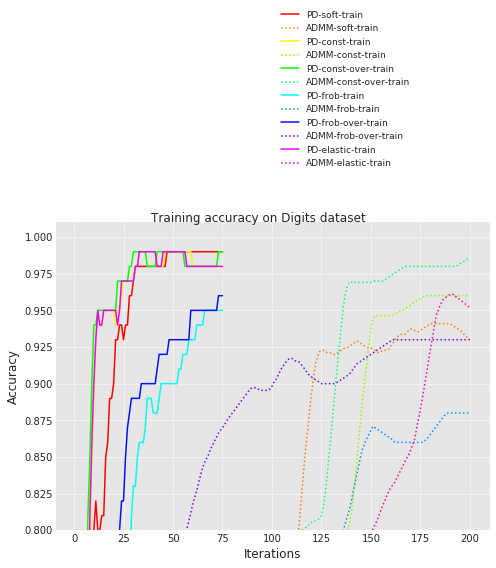

In [237]:
plot_combined_acc_total(suptitle='Training accuracy on Digits dataset',dataset='digits',figname='comb_digits_total',tot='train')

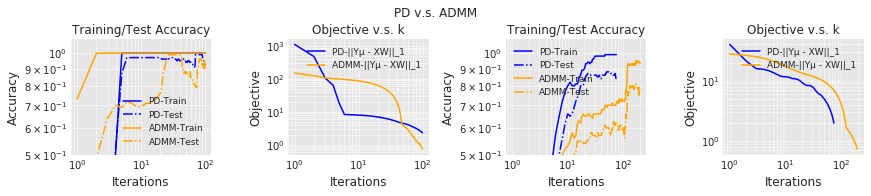

In [72]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(1 + 4*2.8, 2.6), sharey=False)
ax1 = plot_basic(ax1,experiments=['pd_soft_syn','admm_soft_syn'],key1=['acc','acc'],\
                 key2=['train','test'], colors=['blue','orange'],linestyles=['-','-.'],\
                 labels=['PD-Train','PD-Test','ADMM-Train','ADMM-Test'],y_limit=[1.1,0.5],\
                 ylabel='Accuracy',title='acc')
ax2 = plot_basic(ax2,experiments=['pd_soft_syn','admm_soft_syn'],key1=['t1'],key2=['train'],\
                  colors=['blue','orange'],linestyles=['-','-.'],\
                 labels=['PD-||Y\u03BC - XW||_1','ADMM-||Y\u03BC - XW||_1'],\
                 ylabel='Objective',title='loss')
ax3 = plot_basic(ax3,experiments=['pd_soft_digits','admm_soft_digits'],key1=['acc','acc'],\
                 key2=['train','test'], colors=['blue','orange'],linestyles=['-','-.'],\
                 labels=['PD-Train','PD-Test','ADMM-Train','ADMM-Test'],y_limit=[1.1,0.5],\
                 ylabel='Accuracy',title='acc')
ax4 = plot_basic(ax4,experiments=['pd_soft_digits','admm_soft_digits'],key1=['t1'],key2=['train'],\
                  colors=['blue','orange'],linestyles=['-','-.'],\
                 labels=['PD-||Y\u03BC - XW||_1','ADMM-||Y\u03BC - XW||_1'],\
                 ylabel='Objective',title='loss')
fig.suptitle('PD v.s. ADMM',x=0.5,y=1.03,size=12)
#fig.suptitle('PD v.s. ADMM',x=0.8,y=1.03,size=12)
fig.tight_layout()
fig.savefig('Plots/comp_unconst_pd_admm_4.pdf', format='pdf', bbox_inches='tight')

### Unconstrained

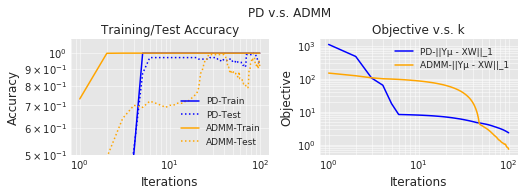

In [66]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(1 + 2*3.2, 2.6), sharey=False)
ax1 = plot_basic(ax1,experiments=['pd_soft_syn','admm_soft_syn'],key1=['acc','acc'],\
                 key2=['train','test'], colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-Train','PD-Test','ADMM-Train','ADMM-Test'],y_limit=[1.1,0.5],\
                 ylabel='Accuracy',title='acc')
ax2 = plot_basic(ax2,experiments=['pd_soft_syn','admm_soft_syn'],key1=['t1'],key2=['train'],\
                  colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-||Y\u03BC - XW||_1','ADMM-||Y\u03BC - XW||_1'],\
                 ylabel='Objective',title='loss')
fig.suptitle('PD v.s. ADMM',x=0.55,y=1.03,size=12)
fig.tight_layout()
fig.savefig('Plots/comp_unconst_pd_admm.pdf', format='pdf', bbox_inches='tight')

### Constrained

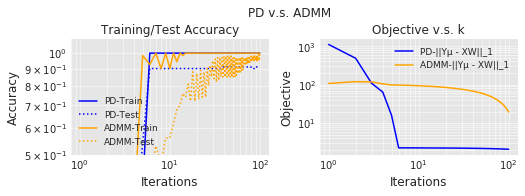

In [67]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(1 + 2*3.2, 2.6), sharey=False)
ax1 = plot_basic(ax1,experiments=['pd_const_syn','admm_const_syn'],key1=['acc','acc'],\
                 key2=['train','test'], colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-Train','PD-Test','ADMM-Train','ADMM-Test'],y_limit=[1.1,0.5],\
                 ylabel='Accuracy',title='acc')
ax2 = plot_basic(ax2,experiments=['pd_const_syn','admm_const_syn'],key1=['t1'],key2=['train'],\
                  colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-||Y\u03BC - XW||_1','ADMM-||Y\u03BC - XW||_1'],\
                 ylabel='Objective',title='loss')
fig.suptitle('PD v.s. ADMM',x=0.55,y=1.03,size=12)
fig.tight_layout()
fig.savefig('Plots/comp_const_pd_admm.pdf', format='pdf', bbox_inches='tight')

### frob

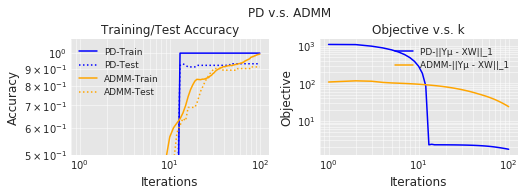

In [69]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(1 + 2*3.2, 2.6), sharey=False)
ax1 = plot_basic(ax1,experiments=['pd_frob_syn','admm_frob_syn'],key1=['acc','acc'],\
                 key2=['train','test'], colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-Train','PD-Test','ADMM-Train','ADMM-Test'],y_limit=[1.1,0.5],\
                 ylabel='Accuracy',title='acc')
ax2 = plot_basic(ax2,experiments=['pd_frob_syn','admm_frob_syn'],key1=['t1'],key2=['train'],\
                  colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-||Y\u03BC - XW||_1','ADMM-||Y\u03BC - XW||_1'],\
                 ylabel='Objective',title='loss')
fig.suptitle('PD v.s. ADMM',x=0.55,y=1.03,size=12)
fig.tight_layout()
fig.savefig('Plots/comp_frob_pd_admm.pdf', format='pdf', bbox_inches='tight')

### elastic

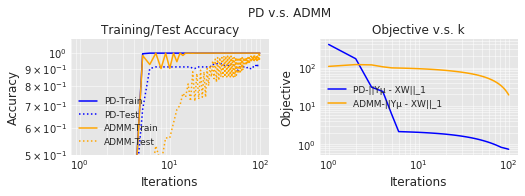

In [74]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(1 + 2*3.2, 2.6), sharey=False)
ax1 = plot_basic(ax1,experiments=['pd_elastic_syn','admm_elastic_syn'],key1=['acc','acc'],\
                 key2=['train','test'], colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-Train','PD-Test','ADMM-Train','ADMM-Test'],y_limit=[1.1,0.5],\
                 ylabel='Accuracy',title='acc')
ax2 = plot_basic(ax2,experiments=['pd_elastic_syn','admm_elastic_syn'],key1=['t1'],key2=['train'],\
                  colors=['blue','orange'],linestyles=['-',':'],\
                 labels=['PD-||Y\u03BC - XW||_1','ADMM-||Y\u03BC - XW||_1'],\
                 ylabel='Objective',title='loss')
fig.suptitle('PD v.s. ADMM',x=0.55,y=1.03,size=12)
fig.tight_layout()
fig.savefig('Plots/comp_elastic_pd_admm.pdf', format='pdf', bbox_inches='tight')